# Exercise 04: Bayesian Inverse Problems

In this notebook, we finally get started with uncertainty quantification for inverse problems.

In essence, the goal of inverse problems is to infer the parameters of a physical model from observations. In the context of uncertainty quantification, we are interested in the uncertainty of the inferred parameters. This uncertainty is quantified by a probability distribution over the parameter space. In this notebook, we use Bayesian inference to infer the so-called posterior distribution of the parameters.

In particular, we show how to use CUQIpy to define the components needed for Bayesian inference. That is, we show how to define the joint probability distribution of the observations and parameters, and how to define the posterior distribution of the parameters by conditioning on the observations. Finally, we show how to sample from the posterior distribution.

**Try to run through parts 1 and 2 before working on the optional exercises**

## Learning objectives
* Define a joint distribution in CUQIpy.
* Define a posterior distribution in CUQIpy.
* Sample a posterior distribution with specific choice of sampler and analyze results.
* Compute point estimates of posterior, e.g., MAP or ML.
* Describe how the high-level "BayesianProblem" combines the above steps into a convenient non-expert interface.

## Table of contents
1. [Defining the posterior distribution](#posterior)
2. [Sampling the posterior](#sampling)
3. [Computing point estimates of the posterior](#pointestimates) ★
4. [Connection to BayesianProblem](#BayesianProbem) ★



## Load modules
As we have seen a few times now, we start of by importing the Python packages we need (including CUQIpy).

In [55]:
import sys; sys.path.append('../../cuqipy/')
import numpy as np
import cuqi
from cuqi.distribution import Gaussian, JointDistribution, GaussianCov
from cuqi.problem import BayesianProblem
from cuqi.testproblem import Deconvolution1D, Deconvolution2D

## 1. Defining the posterior distribution <a class="anchor" id="posterior"></a>

Solving a Bayesian inverse problem amounts to characterizing the so-called posterior distribution.
In short, the posterior is defined (ignoring scaling constants) as the product of the prior and the likelihood.

To elaborate, consider an inverse problem
$$b=A(x)+e, \quad b\in\mathbb{R}^m, \, x\in \mathbb{R}^n,$$
where $A: \mathbb{R}^n \to \mathbb{R}^m$ is the forward model of the inverse problem and $e\in\mathbb{R}^m$ is additive measurement noise.

### Forward model and data
Before defining the likelihood and prior (which are needed for the posterior) we first need an inverse problem to work with.

For this example let us revisit the Deconvolution testproblem and extract a CUQIpy model and some data (in this case generated from the default phantom).

In [56]:
A, y_obs, probInfo = Deconvolution1D.get_components(dim=50)
A, y_obs, probInfo = Deconvolution1D(dim=50).model_data_info
n = A.domain_dim

c:\Users\Nicolai\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


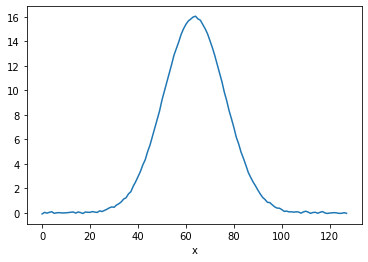

In [57]:
# Plot the data
y_obs.plot()

In [58]:
print(probInfo)

ProblemInfo with the following set attributes:
['exactData', 'infoString', 'exactSolution']
 infoString: Noise type: Additive Gaussian with std: 0.05


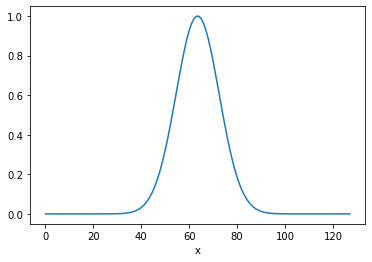

In [59]:
# Plot the true solution
probInfo.exactSolution.plot()

### Bayesian model

The default phantom in the Deconvolution testproblem is well-represented by a Gaussian distribution and so let us define an i.i.d. Gaussian distribution as the prior (here the dimension is inferred from either the mean or the std).

From the problem info string above, we see that the noise is additive Gaussian with std 0.05 and so the data distribution $p(b|x)$ will also follow a Gaussian distribution (as seen in exercise 03):

\begin{align*}

x &\sim \mathcal{N}(0, \sigma_x^2 I)\\
y &\sim \mathcal{N}(Ax, \sigma_y^2 I)

\end{align*}

In [ ]:
x = GaussianCov(mean=np.zeros(n), cov=0.1**2)
y = GaussianCov(mean=A@x, cov=0.05**2)

### Define joint distribution

$$
p(y,x) = p(y \mid x)p(x)
$$

In [ ]:
joint = JointDistribution(y, x)
print(joint)

### The posterior

The posterior pdf is given by Bayes rule

$$p(x|b)\propto p(b|x)p(x),$$

where $p(\cdot)$ are probability density functions (pdfs). Here $p(b|x)$ describes the distribution of the data given $x$ and $p(x)$ the distribution of $x$.

Once we have the likelihood and prior, we have all components to define the posterior distribution. This is then simply done as follows.

In [ ]:
joint._allow_reduce = True # TODO
posterior = joint(y=y_obs)
print(posterior)

#### ★ Try yourself (optional):  
The posterior is essentially just another CUQIpy distribution. Have a look at `posterior?` to see what attributes and methods are available. What happends if you call the `sample` method?

In [ ]:
# Your code here




## 2. Sampling the posterior <a class="anchor" id="sampling"></a>
In CUQIpy, we provide a number of samplers in the sampler module. All samplers have the same signature, namely
`Sampler(target, ...)`, where `target` is the target CUQIpy distribution and `...` indicates any (optional) arguments.

In the case of the posterior above which is defined from a linear model and Gaussian likelihood and prior, the Linear Randomize-then-Optimize (Linear_RTO) sampler is a good choice. Like any of the other samplers, we set-up the sampler by simply providing the target distribution

In [ ]:
sampler = cuqi.sampler.Linear_RTO(posterior)

and then running the sampler and storing the samples in the variable `samples`.

In [ ]:
samples = sampler.sample(500)

Similar to directly sampling distributions in CUQIpy, when sampling using the sampler module the returned object is a `cuqi.samples.Samples` object. As we have already seen this object has a number of methods available. In this case, we are interested in evaluating if the sampling went well. To do this we can have a look at the chain history for 2 different values.

In [ ]:
samples.plot_chain([30, 45]);

In both cases the chains look very good without much initial burn-in. This is in large part due to the Linear_RTO sampler. For the sake of presentation let us remove the first 100 samples using the `burnthin` method (see `samples.burnthin?`) and store the burnthinned samples in a new variable.

In [ ]:
samples_final = samples.burnthin(Nb=100)

Finally, we can plot a credibility interval of the samples and compare to the exact solution (from probInfo)

In [ ]:
samples_final.plot_ci(95, exact=probInfo.exactSolution)

### Trying out other samples

The Linear_RTO sampler can only sample Gaussian posteriors that also have an underlying linear model. It is possible to try out other CUQIpy samplers (which also work for a broader range of problems). For example:

* **pCN** - Works OK with enough samples (>5000 in this case)
* **CWMH** - Works OK with enough samples (>5000 in this case)
* **NUTS** - A well established sampler in literature. Also NUTS requires gradients!

#### ★ Try yourself (optional):  
Try sampling the posterior above using the NUTS, CWMH or pCN sampler (see e.g. the help documentation for the sampler to get more info on it).

Compare results (chain, credibility interval etc.) to the results from Linear_RTO.

In [ ]:
# Your code here






## 3. High-level interface (BayesianProblem) ★ <a class="anchor" id="BayesianProblem"></a>

Finally, we make the connection to the "BayesianProblem" CUQIpy that we saw in exercise 01 for the non-expert interface. Essentially the BayesianProblem tries to conveniently wrap all of the steps we have seen earlier in this notebook into a single object.

In [ ]:
x = GaussianCov(mean=np.zeros(n), cov=0.1**2)
y = GaussianCov(mean=A@x, cov=0.05**2).to_likelihood(y_obs)
BP = BayesianProblem(y, x)
BP.UQ(exact=probInfo.exactSolution)

For example, the `sample_posterior` method defines a posterior distribution (in the same way as we saw earlier), selects an appropriate CUQIpy sampler and runs the sampler. 

*The sampler selection is still work-in-progress and part of the CUQI project is to figure out which samplers are best suited for which inverse problems.*

In [ ]:
samples = BP.sample_posterior(1000)

Similar to distributions and samplers the BayesianProblem sample method returns a `cuqi.samples.Samples` object so we can e.g. plot the credibility interval easily:

In [ ]:
samples.plot_ci(95,exact=probInfo.exactSolution)

MAP (and ML) estimates are also supported

In [ ]:
x_map = BP.MAP()
x_map.plot()



In [ ]:
probInfo.exactSolution.plot()

In [ ]:
BP.sample_prior(5).plot()

#### ★ Try yourself (optional):  

- Try switching the testproblem from Deconvolution1D to Deconvolution2D
- Try another prior

### Where to go from here?

## 4. Computing point estimates of the posterior ★  <a class="anchor" id="pointestimates"></a>

In Bayesian inverse problems one may also be interested in computing point estimates of the posterior, or perhaps even the likelihood. There are generally two ways to go about this 1) compute point estimates from the posterior samples and 2) compute point estimates using optimization-based methods.

In this section, we are going to show-case the CUQIpy solver module aimed at computing point estimates using the second approach.

### MAP estimation
The Maxiumum a posteriori (MAP) estimate is equal to the mode of the posterior distribution, and can be computed by maximizing the pdf (or logpdf) of the posterior. Using the CUQIpy solver module this follows a similar flow to what we have seen before with one exception. In this case, we are forced to provide an initial guess. In this case we provide the initial guess as a CUQIarray with the posterior geometry, to allow for later plotting of the map estimate (this will most likely be handled automatically in future versions of CUQIpy)

In [ ]:
x0 = cuqi.samples.CUQIarray(np.zeros(n), geometry=posterior.geometry)

Given the initial guess, we simply set up a solver to maximize the logpdf of the posterior

In [ ]:
MAP = cuqi.solver.maximize(posterior.logpdf, x0)

With this we can simpy run the solve method to compute the MAP estimate

In [ ]:
x_map, info = MAP.solve()
x_map.plot()
probInfo.exactSolution.plot()

The info output argument contains some useful information to validate if the optimization went well or not. In this case we can check the convergence status and iteration number.

*Note: Compared to the sampler module, in the solver module we have to resort to using a bit more "Python lingo" to get our desired results. This should indicate that this module is still at its early design-states*.

In [ ]:
print(info["message"])
print("Number of iterations: {}".format(info["nit"]))

#### Try yourself (optional):  
If time permits, try playing around with the solver module. Suggested things to try:
* Try computing the maximum likelihood (ML) estimate. What do you expect the ML estimate to look like?
* By default the solver will use a numerical estimate of the gradient of the objective function. Can you find a way to pass the actual gradient? Did this increase the convergence speed?

In [ ]:
# Your code here




